In [165]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from quantbullet.preprocessing.transformers import FlatRampTransformer
from numpy.linalg import lstsq

In [166]:
np.random.seed(42)
n_samples = int( 10e3 )
df = pd.DataFrame({
    'x1': 5 + np.random.randn(n_samples) * 2,
    'x2': 10 + np.random.randn(n_samples) * 2,
    'x3': np.random.choice([0, 1, 2], size=n_samples, p=[0.25, 0.25, 0.5])
})

df['x3'] = df['x3'].astype('category')

df['y'] = 2 * np.cos(df['x1']) + 3 * np.sin(df['x2']) +\
    np.random.randn(n_samples) * 1 + \
        np.random.normal(loc = df['x3'].cat.codes, scale=0.5) + 10
        
x1_trans = FlatRampTransformer(
    knots = [-1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11],
    include_bias=True
)

x2_trans = FlatRampTransformer(
    knots = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    include_bias=True
)

train_df = np.concatenate([
    x1_trans.fit_transform(df['x1']),
    x2_trans.fit_transform(df['x2']),
    pd.get_dummies(df['x3'], prefix='x3') * 1
], axis=1)

train_df = pd.DataFrame(train_df, columns = x1_trans.get_feature_names_out().tolist() 
                        + x2_trans.get_feature_names_out().tolist()
                        + [ 'x3_' + str(cat) for cat in df['x3'].cat.categories.tolist() ])

In [167]:
train_df.head()

,x1_bias,x1_le_-1,x1_-1_1,x1_1_2,x1_2_3,x1_3_4,x1_4_5,x1_5_6,x1_6_7,x1_7_8,...,x2_9_10,x2_10_11,x2_11_12,x2_12_13,x2_13_14,x2_14_15,x2_gt_15,x3_0,x3_1,x3_2
0,1.0,-1.0,1.0,2.0,3.0,4.0,5.000000,5.993428,6.000000,7.0,...,9.000000,10.000000,11.0,12.000000,13.0,14.0,15.0,1.0,0.0,0.0
1,1.0,-1.0,1.0,2.0,3.0,4.0,4.723471,5.000000,6.000000,7.0,...,9.389001,10.000000,11.0,12.000000,13.0,14.0,15.0,0.0,0.0,1.0
2,1.0,-1.0,1.0,2.0,3.0,4.0,5.000000,6.000000,6.295377,7.0,...,9.000000,10.000000,11.0,12.000000,13.0,14.0,15.0,0.0,0.0,1.0
3,1.0,-1.0,1.0,2.0,3.0,4.0,5.000000,6.000000,7.000000,8.0,...,10.000000,10.220836,11.0,12.000000,13.0,14.0,15.0,0.0,0.0,1.0
4,1.0,-1.0,1.0,2.0,3.0,4.0,4.531693,5.000000,6.000000,7.0,...,10.000000,11.000000,12.0,12.394357,13.0,14.0,15.0,0.0,0.0,1.0


In [168]:
feature_groups = {'x1': x1_trans.get_feature_names_out().tolist(), 
                  'x2': x2_trans.get_feature_names_out().tolist(),
                  'x3': [ 'x3_' + str(cat) for cat in df['x3'].cat.categories.tolist() ]}

## Piecewise Log Product Model

In [318]:
from quantbullet.optimizer.piecewise_log_product import PiecewiseLogProductModel

plpm = PiecewiseLogProductModel( min_log_value=1e-12, xtol=1e-8, gtol=1e-8, ftol=1e-8 )

In [319]:
plpm.fit( X=train_df, y=df['y'], feature_groups=feature_groups, verbose=2 )

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         6.5533e+04                                    1.45e+04    
       1              2         4.2031e+04      2.35e+04       5.39e+00       1.80e+03    
       2              3         4.0571e+04      1.46e+03       1.08e+01       4.21e+03    
       3              5         3.6590e+04      3.98e+03       2.69e+00       5.29e+02    
       4              6         3.4753e+04      1.84e+03       5.39e+00       1.88e+03    
       5              8         3.3621e+04      1.13e+03       2.69e+00       4.08e+02    
       6              9         3.2295e+04      1.33e+03       5.39e+00       7.83e+03    
       7             10         3.0604e+04      1.69e+03       1.08e+01       2.59e+03    
       8             12         2.9785e+04      8.19e+02       5.39e+00       4.60e+02    
       9             14         2.9258e+04      5.27e+02       2.69e+00       1.23e+02    

In [320]:
df['model_predict'] = plpm.predict(train_df, feature_groups=feature_groups)

In [321]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(df['y'], df['model_predict'])
print(f'Mean Squared Error: {mse:.4f}')

Mean Squared Error: 2.1220


In [322]:
df['x1_bins'] = pd.cut( df['x1'], bins=x1_trans.get_bins_and_labels()[0], labels=x1_trans.get_bins_and_labels()[1] )
df['x2_bins'] = pd.cut( df['x2'], bins=x2_trans.get_bins_and_labels()[0], labels=x2_trans.get_bins_and_labels()[1] )

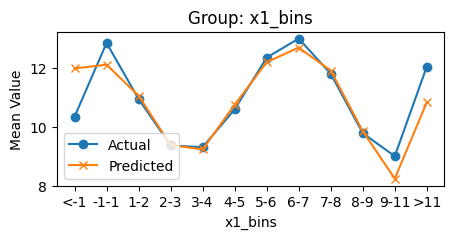

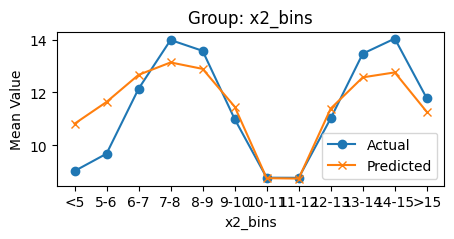

In [323]:
for group in ['x1_bins', 'x2_bins']:
    plt.figure(figsize=(5, 2))
    summary = df.groupby(group, observed=True).agg({'y': 'mean', 'model_predict': 'mean'})
    plt.plot(summary.index, summary['y'], label='Actual', marker='o')
    plt.plot(summary.index, summary['model_predict'], label='Predicted', marker='x')
    plt.title(f'Group: {group}')
    plt.xlabel(group)
    plt.ylabel('Mean Value')
    plt.legend()